### Pre-processing procedures:

1. Forward-fill valuation-related items, including FCF, dividends
2. Use market cap/price column and valuation columns to calculate ratios
3. Back-fill revere classifications
4. Cross-sectional z-scores
5. One-hot classifications

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding

from keras.layers import LSTM
from keras import backend as K
from keras import regularizers

import seaborn as sns

from sklearn import metrics

%matplotlib inline

In [3]:
bins = 5
ret_seq = False
timestep = 32

In [4]:
# Import data from csv

all_data = pd.read_csv('~/Projects/HS-Composite/HS_Composite_Weekly.csv',
                      parse_dates = ['Date'], infer_datetime_format = True)

#all_data = pd.read_csv('C:/Users/oou/Desktop/Analytics/Machine Learning/HS-Composite/HS_Composite_Weekly.csv',
#                      parse_dates = ['Date'], infer_datetime_format = True)
    
#all_data = pd.read_csv('/Users/Owen/Documents/Machine Learning/Projects/Hang Seng Composite/HS_Composite.csv',
#                       parse_dates = ['Date'], infer_datetime_format = True).set_index(['Date', 'Ticker'])

In [5]:
#all_data = all_data[(all_data['Ticker']!='LX75953') & (all_data['Ticker']!='LX87416')]

In [6]:
def insert_na(series, time_step):
    
    output = np.zeros_like(series, dtype=float)
    
    length = output.shape[0]//time_step * time_step
    output[length:] = np.nan
    
    return output

In [7]:
# Convert dates to numbers
all_data['Date Num'] = all_data['Date'].rank(method='dense')

# Count discontinuity in dates
all_data['Count'] = all_data.groupby('Ticker')['Date Num'].transform(lambda x: np.append(0, np.cumsum(np.diff(x)>1)))

# Mark dates out of bounds as NaN
all_data['Count_na'] = all_data.groupby(['Ticker','Count'])['Count'].transform(lambda x: insert_na(x, timestep))

all_data.set_index(['Date', 'Ticker'], inplace=True)

**The Forward fill FY1 PE line should be changed. Should forward fill EPS and then calculate PE**

In [8]:
def process_data(data):
    
    #Forward fill Valuation Data
    data.loc[:,'Book Value':'1M EPS Revision'] = data.loc[:,'Book Value':'1M EPS Revision'].groupby(level = 1).ffill()
    
    #Fill N/A Estimate data with 0 (regard it as no signal)
    data.loc[:,'1M EPS Revision':'FY1 EPS Growth'] = data.loc[:,'1M EPS Revision':'FY1 EPS Growth'].fillna(value = 0)
    
    #Calculate valuation ratios

    data['PB Ratio'] = data['Market Cap']/data['Book Value']
    ata['Dividend Yield'] = data['Total Dividends']/data['Market Cap']
    data['Earnings Yield'] = data['EPS']/data['Price']
    data['FCF Yield'] = data['Free Cash Flow']/data['Market Cap']
    data['Log Market Cap'] = np.log(data['Market Cap'])

    data.fillna(0, inplace = True)
    
    return data

In [9]:
#Forward fill Valuation Data
all_data.loc[:,'Book Value':'1M EPS Revision'] = all_data.loc[:,'Book Value':'1M EPS Revision'].groupby(level = 1).ffill()

#Fill N/A Estimate data with 0 (regard it as no signal)
all_data.loc[:,'1M EPS Revision':'FY1 EPS Growth'] = all_data.loc[:,'1M EPS Revision':'FY1 EPS Growth'].fillna(value = 0)

In [10]:
#Calculate valuation ratios

all_data['PB Ratio'] = all_data['Market Cap']/all_data['Book Value']
all_data['Dividend Yield'] = all_data['Total Dividends']/all_data['Market Cap']
all_data['Earnings Yield'] = all_data['EPS']/all_data['Price']
all_data['FCF Yield'] = all_data['Free Cash Flow']/all_data['Market Cap']
all_data['Log Market Cap'] = np.log(all_data['Market Cap'])

**Cut returns into two bins**

In [11]:
all_data['Return Rank'] = all_data['Returns'].groupby('Date').transform(lambda x: pd.qcut(x, bins, labels = False))
#all_data['Return Rank'] = all_data.groupby('Date')['Returns'].transform(lambda x: x.rank() <= 50)

**Standarising features**

In [12]:
zscore = lambda x: (x - x.mean())/x.std()

zscore_cols = ['-1W Return', '-2W Return', '7D Volatility', '30D Volatility', 'MACD',
               'RSI', '1M Turnover %', 'Log Market Cap']

zscores = [col+' z-score' for col in zscore_cols]

grp_zscore_cols = ['Gross Profitability', 'Return on Equity', 'Gross Margin', '1-Year Sales Growth',
                   '5-Year Sales Growth', '1-Year EPS Growth', '5-Year EPS Growth', 'EBIT Interest Coverage',
                   'Book Leverage', '1M EPS Revision', 'FY1 PE', 'FY0 EPS Surprise', 'FY1 EPS Growth',
                   'PB Ratio', 'Dividend Yield', 'Earnings Yield', 'FCF Yield']

grp_zscores = [col+' grp z-score' for col in grp_zscore_cols]

all_data[zscores] = all_data.groupby('Date')[zscore_cols].transform(zscore)
    
#all_data[grp_zscores] = all_data.groupby('Date')[grp_zscore_cols].transform(zscore)
    
all_data[grp_zscores] = all_data.groupby(['Date', 'HSCI Industry'])[grp_zscore_cols].transform(zscore)

#all_data['Returns'] = all_data.groupby('Date')['Returns'].transform(zscore)

**Create one-hot arrays for Revere classification and return ranking**

In [13]:
#new_index = pd.MultiIndex.from_product(all_data.index.levels)
#all_data = all_data.reindex(new_index, fill_value=0)
## pad the dataframe with zeros so that all stocks have complete history

In [14]:
all_data = all_data[all_data['Count_na'].notnull()].drop(['Date Num', 'Count', 'Count_na'], axis=1)

In [15]:
all_data.sort_index(level = [1,0], inplace = True)
all_data.fillna(0, inplace = True)

In [16]:
#CHANGE 36 TO 35 WHEN DOING MULTI-CLASS CLASSIFICATION AS THE 'RETURN RANKS' COLUMN IS ONE-HOTTED
def reshape_data(all_data, num_classes):
    
    if num_classes == 2:
        
        all_data = pd.get_dummies(all_data,
                          prefix={'HSCI Industry': 'Ind'},
                          prefix_sep='_',
                          columns=['HSCI Industry'])
        
        x_data_reshaped = all_data.iloc[:, 36:].values.reshape(-1, timestep, 36)
        y_data_reshaped = all_data['Return Rank'].values.reshape(-1, timestep, 1)
        #returns_reshaped = all_data['Returns'].values.reshape(-1, timestep, 1)
        #y_data_reshaped = all_data.iloc[::, -2:].values.reshape(2832, timestep, 2)
    else:
        
        #returns_reshaped = all_data['Returns'].values.reshape(1000, timestep, 1)
        
        all_data = pd.get_dummies(all_data,
                          prefix={'HSCI Industry': 'Ind','Return Rank': 'Ret_Rank'},
                          prefix_sep='_',
                          columns=['HSCI Industry', 'Return Rank'])
        
        x_data_reshaped = all_data.iloc[:, 35:-num_classes].values.reshape(-1, timestep, 36)
        y_data_reshaped = all_data.iloc[:, -num_classes:].values.reshape(-1, timestep, num_classes)
        
    return x_data_reshaped, y_data_reshaped#, returns_reshaped

In [17]:
x_data_reshaped, y_data_reshaped = reshape_data(all_data, bins)

In [18]:
#x_data_reshaped = x_data_reshaped[np.sum(returns_reshaped, axis = (1,2))!=0,:,:]
#y_data_reshaped = y_data_reshaped[np.sum(returns_reshaped, axis = (1,2))!=0,:,:]

In [19]:
if ret_seq == False: y_data_reshaped = y_data_reshaped[:,-1,:] #last return of each sequence (for return_sequences = False)

In [20]:
x_data_reshaped.shape

(5318, 32, 36)

In [21]:
#shuffle = np.random.permutation(x_data_reshaped.shape[0])
shuffle = np.arange(x_data_reshaped.shape[0])

x_train = x_data_reshaped[shuffle[0:4000],:,:]
y_train = y_data_reshaped[shuffle[0:4000],:]

x_dev = x_data_reshaped[shuffle[4000:4700],:,:]
y_dev = y_data_reshaped[shuffle[4000:4700],:]

x_test = x_data_reshaped[shuffle[4700:],:,:]
y_test = y_data_reshaped[shuffle[4700:],:]

In [22]:
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


In [29]:
def create_model(dropout_1 = 0, dropout_2 = 0, l2_1 = 0, l2_2 = 0, lr = 0.001, num_classes = 2):

    model = Sequential()

    model.add(LSTM(128, input_shape = (timestep, 36), return_sequences=True, dropout=dropout_1,
                   kernel_regularizer=regularizers.l2(l2_1)))
    #kernel_regularizer=regularizers.l2(0.1)


    model.add(LSTM(128, dropout=dropout_2,return_sequences=True, kernel_regularizer=regularizers.l2(l2_2)))
    #model.add(Dropout(0.1))
    
    model.add(LSTM(128, dropout=dropout_2,return_sequences=ret_seq, kernel_regularizer=regularizers.l2(l2_2)))
    
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0)))
    
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0)))

    if num_classes == 2:
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr = lr),
                      metrics=['binary_accuracy', precision])
    else:
        model.add(Dense(num_classes, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr = lr),
                      metrics=['categorical_accuracy'])
    
    return model

In [30]:
model = create_model(0.3,0.3,0,0, 0.0001, bins)

In [34]:
result = model.fit(x_train, y_train, epochs=40, batch_size=128, verbose=2, validation_data = (x_dev, y_dev))

Train on 4000 samples, validate on 700 samples
Epoch 1/40
 - 6s - loss: 1.6091 - categorical_accuracy: 0.2050 - val_loss: 1.6090 - val_categorical_accuracy: 0.2043
Epoch 2/40
 - 5s - loss: 1.6066 - categorical_accuracy: 0.2205 - val_loss: 1.6060 - val_categorical_accuracy: 0.2229
Epoch 3/40
 - 5s - loss: 1.6033 - categorical_accuracy: 0.2417 - val_loss: 1.6025 - val_categorical_accuracy: 0.2314
Epoch 4/40
 - 5s - loss: 1.5969 - categorical_accuracy: 0.2372 - val_loss: 1.5974 - val_categorical_accuracy: 0.2371
Epoch 5/40
 - 5s - loss: 1.5927 - categorical_accuracy: 0.2402 - val_loss: 1.5925 - val_categorical_accuracy: 0.2400
Epoch 6/40
 - 5s - loss: 1.5875 - categorical_accuracy: 0.2537 - val_loss: 1.5913 - val_categorical_accuracy: 0.2429
Epoch 7/40
 - 5s - loss: 1.5889 - categorical_accuracy: 0.2560 - val_loss: 1.5895 - val_categorical_accuracy: 0.2471
Epoch 8/40
 - 5s - loss: 1.5826 - categorical_accuracy: 0.2672 - val_loss: 1.5889 - val_categorical_accuracy: 0.2443
Epoch 9/40
 - 5s 

In [35]:
if ret_seq:
    target_names = ['Class'+str(n) for n in range(bins)]
    y_pred = model.predict(x_test)
    print(metrics.classification_report(y_test.argmax(2).flatten(), y_pred.argmax(2).flatten(), target_names=target_names))

else:
    target_names = ['Class'+str(n) for n in range(bins)]
    y_pred = model.predict(x_test)
    print(metrics.classification_report(y_test.argmax(1), y_pred.argmax(1), target_names=target_names))

             precision    recall  f1-score   support

     Class0       0.23      0.23      0.23       124
     Class1       0.28      0.23      0.25       125
     Class2       0.23      0.23      0.23       128
     Class3       0.20      0.16      0.18       116
     Class4       0.26      0.34      0.30       125

avg / total       0.24      0.24      0.24       618



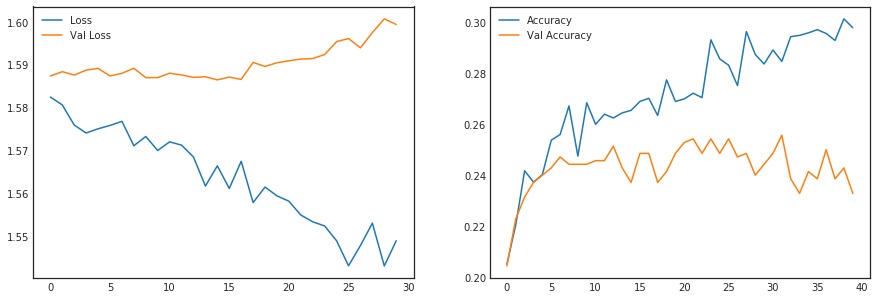

In [36]:
plt.figure(figsize = (15,5))
sns.set_style("white")

plt.subplot(121)
plt.plot(result.history['loss'][10:])
plt.plot(result.history['val_loss'][10:])
plt.legend(['Loss', 'Val Loss'])

plt.subplot(122)

if bins==2:
    plt.plot(result.history['binary_accuracy'])
    plt.plot(result.history['val_binary_accuracy'])
else:
    plt.plot(result.history['categorical_accuracy'])
    plt.plot(result.history['val_categorical_accuracy'])
    
plt.legend(['Accuracy', 'Val Accuracy']);

#plt.subplot(223)
#plt.plot(result.history['precision'])
#plt.plot(result.history['val_precision'])
#plt.legend(['Precision', 'Val Precision']);

In [32]:
y_pred = model.predict(x_train)
metrics.confusion_matrix(y_train, np.round(y_pred))

ValueError: multilabel-indicator is not supported

In [33]:
tune_results = pd.DataFrame(np.zeros((40, 9)),
                            columns = ['dropout_1', 'dropout_2', 'l2_1', 
                                       'l2_2', 'loss', 'accuracy',
                                      'val_loss', 'val_accuracy', 'lr'])

for i in range(40):
    
    #if i % 5 == 0: print("Running iteration {}-{}".format(i, i+5))
    print("Running iteration {}".format(i))
          
    dropout_1 = np.random.uniform(0, 1)
    dropout_2 = np.random.uniform(0, 1)
    lr = np.exp(np.random.uniform(-6, 0))
    l2_1 = np.exp(np.random.uniform(-4, 0))
    l2_2 = np.exp(np.random.uniform(-4, 0))
    
    
    model = create_model(dropout_1, dropout_2, l2_1, l2_2, lr, bins)
    result = model.fit(x_train, y_train, epochs=80, batch_size=128, verbose=0, validation_data = (x_dev, y_dev))
    
    tune_results.iloc[i] = [dropout_1, dropout_2, l2_1, l2_2,
                            result.history['loss'][-1], result.history['binary_accuracy'][-1],
                            result.history['val_loss'][-1], result.history['val_binary_accuracy'][-1], lr]
                           #result.history['precision'][-1], result.history['val_precision'][-1]]
    

Running iteration 0


KeyError: 'binary_accuracy'

In [68]:
tune_results

,dropout_1,dropout_2,l2_1,l2_2,loss,accuracy,val_loss,val_accuracy,lr
0,0.931612,0.967210,0.067904,0.869231,6.923992e-01,0.526667,6.930782e-01,0.520,0.007475
1,0.205958,0.363644,0.029457,0.816038,6.920340e-01,0.526667,6.927779e-01,0.520,0.047772
2,0.646210,0.790830,0.792973,0.035568,6.921743e-01,0.526667,6.925189e-01,0.520,0.027272
3,0.592776,0.856450,0.152186,0.030768,9.026136e+05,0.505000,9.078088e+05,0.575,0.896186
4,0.662456,0.343386,0.027930,0.077732,6.917593e-01,0.526667,6.923962e-01,0.520,0.007941
5,0.935803,0.367336,0.041379,0.041885,6.920245e-01,0.526667,6.926640e-01,0.520,0.010829
6,0.123315,0.264835,0.039293,0.081507,6.918415e-01,0.526667,6.924130e-01,0.520,0.014364
7,0.195417,0.551929,0.018667,0.317075,6.936207e-01,0.526667,6.931338e-01,0.520,0.022893
8,0.206481,0.511752,0.073458,0.225111,6.920207e-01,0.526667,6.926341e-01,0.520,0.005911
9,0.844901,0.745115,0.380857,0.139344,6.921481e-01,0.526667,6.928127e-01,0.520,0.004063


In [190]:
metrics.confusion_matrix(y_train.argmax(1), y_pred.argmax(1))

array([[1000]])

In [44]:
model.evaluate(x_test, y_test)

200/200 [==============================] - 0s     


[0.76113231897354128, 0.53000000000000003, 0.5427497005462647]

In [16]:
tune_reg = pd.read_csv('C:/Users/oou/Desktop/Analytics/Machine Learning/Reg_Tune.csv')

In [98]:
tune_results.to_csv('/Users/Owen/Documents/Machine Learning/Projects/Hang Seng Composite/Reg_Tune.csv')

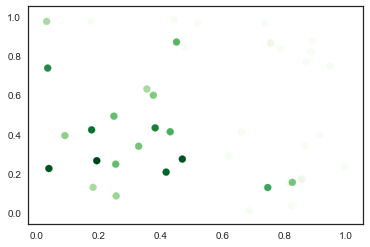

In [194]:
plt.figure()
sns.set_style("white")
plt.scatter(tune_results['dropout_1'], tune_results['dropout_2'], c = tune_results['val_binary_accuracy'], cmap = 'Greens')

In [26]:
tune_reg.iloc[57]

dropout_1              0.516177
dropout_2              0.310560
l2_1                   0.002840
l2_2                   0.479195
loss                   0.838360
binary_accuracy        0.547500
val_loss               0.818783
val_binary_accuracy    0.596774
Name: 57, dtype: float64